# Undersampling and oversampling imbalanced data

## Введение
В задачах машинного обучения часто встречается значительная разница в частоте различных классов данных. Например, при обнаружении рака мы можем ожидать, что в наборах данных будет большое количество отрицательных результатов и относительно небольшое количество положительных.

Общая производительность модели, обученной на таких данных, ограничена её способностью предсказывать редкие случаи. В задачах, где эти редкие случаи имеют одинаковую или меньшую важность по сравнению с частыми, этот вопрос может проявиться только на этапе "тонкой настройки" модели. Но в задачах, где редкие случаи важны или являются основной целью (например, в случае с обнаружением рака), их редкость становится первоочередной задачей при построении модели.

Важно также учитывать метрику ошибки: чем важнее редкие наблюдения, тем больше метрика должна штрафовать за недостаточную точность в их предсказании.

Для работы с несбалансированными наборами данных существует множество техник. Наиболее простыми из них являются методы выборки: уменьшение количества частых классов (undersampling), увеличение редких классов (oversampling) или их комбинация.

## Мотивация

Для иллюстрации влияния несбалансированности классов на производительность классификации используем визуализацию. Она показывает, как относительное количество точек на класс влияет на работу классификатора с линейным ядром (например, SVM).

Когда один класс доминирует, оптимальное решение модели может "разрушиться", классифицируя все точки как принадлежащие к доминирующему классу. Однако, по мере выравнивания распределения классов, классификатор становится менее предвзятым.
`imbalanced-learn` documentation [here](http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html).

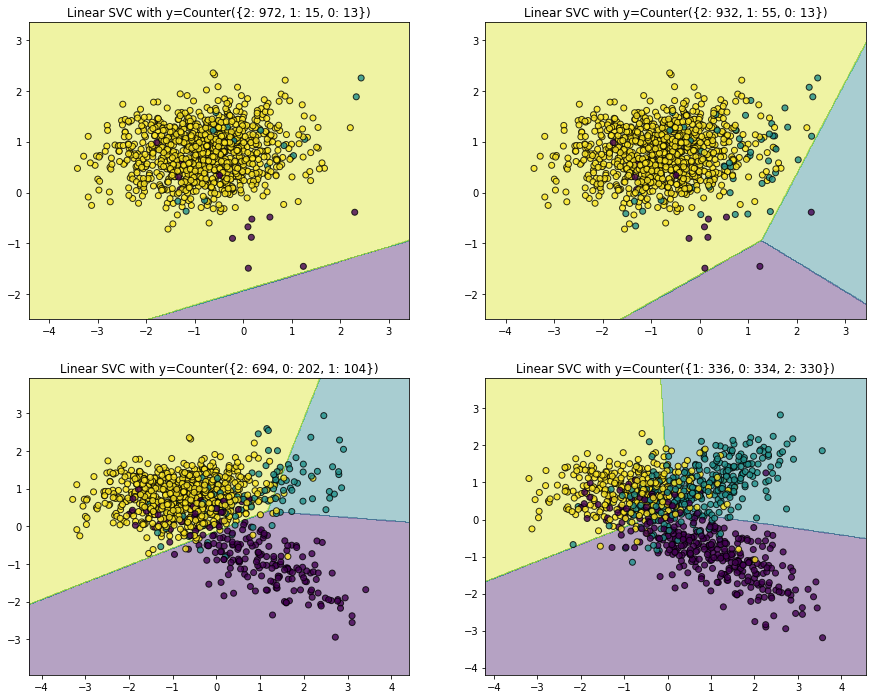

In [24]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification

def create_dataset(n_samples=1000, weights=(0.01, 0.01, 0.98), n_classes=3,
                   class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

ax_arr = (ax1, ax2, ax3, ax4)
weights_arr = ((0.01, 0.01, 0.98), (0.01, 0.05, 0.94),
               (0.2, 0.1, 0.7), (0.33, 0.33, 0.33))
for ax, weights in zip(ax_arr, weights_arr):
    X, y = create_dataset(n_samples=1000, weights=weights)
    clf = LinearSVC().fit(X, y)
    plot_decision_function(X, y, clf, ax)
    ax.set_title('Linear SVC with y={}'.format(Counter(y)))

Как вы можете видеть, когда набор данных сильно доминирует одним или несколькими классами, в ущерб другим классам, оптимальное решение может свестись к коллапсу: модель, которая просто классифицирует все или большинство точек как принадлежащие доминирующему классу (как показано на первых двух визуализациях в этой сетке). Однако, когда количество наблюдений для каждого класса приближается к равномерному распределению, классификатор становится всё менее и менее смещённым.

Повторная выборка (resampling) точек, подаваемых в модель, является самым простым способом исправить ошибки модели, возникающие из-за проблем с редкими классами. Не все наборы данных сталкиваются с этой проблемой, но для тех, у которых она есть, её решение — важный ранний шаг в моделировании данных.

## Getting some sample data

Для иллюстрации мы будем использовать следующие данные(взятые из документации `sklearn`):

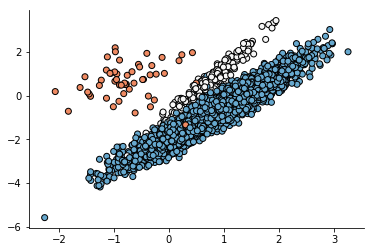

In [25]:
import seaborn as sns
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)

import matplotlib.pyplot as plt
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
fig = plt.Figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:, 1], c=colors, **kwarg_params)
sns.despine()

## Raw over- and under- sampling

Группа исследователей реализовала полный набор современных методов сэмплирования данных в модуле `imbalanced-learn` (imblearn), который является дополнительным модулем для `sklearn`. Этот подмодуль устанавливается по умолчанию вместе с базовой установкой `sklearn`, поэтому он должен быть доступен всем. Также доступна документация imblearn.

`imblearn` реализует методы `oversampling` и `undersampling` с использованием специализированных классов.

In [26]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

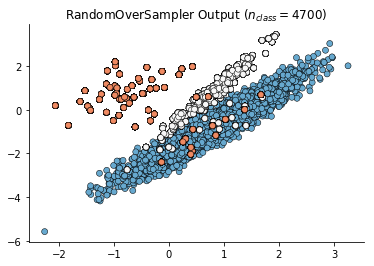

In [27]:
ros = RandomOverSampler(random_state=0)
ros.fit(X, y)
X_resampled, y_resampled = ros.sample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomOverSampler Output ($n_{class}=4700)$")
pass

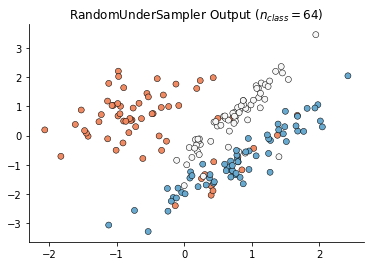

In [28]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.sample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomUnderSampler Output ($n_{class}=64)$")
pass

На первом графике мы провели oversampling, дублируя точки из редкого класса 2 и крайне редкого класса 3, чтобы их численность соответствовала распространённому классу 1. В результате многие точки были "скопированы" огромное количество раз, так как в классе 2 всего 64 уникальные точки, тогда как в классе 1 их 4700.

На втором графике мы применили undersampling. Здесь ситуация обратная: классы 1 и 2 сокращены по числу наблюдений до уровня класса 3, у которого всего 64 точки.

На каком из этих двух наборов точек лучше обучать классификатор? В крайних случаях, когда количество наблюдений в редких классах очень мало, oversampling предпочтительнее, так как вы не потеряете важную информацию о распределении других классов в наборе данных. Например, если в классе 3 было бы всего 5 наблюдений, обучение классификатора на 15 точках (5 умножить на 3) из undersampled-набора стало бы практически невозможным!

Однако вне таких случаев производительность моделей, обученных на данных после oversampling или undersampling, будет практически одинаковой. Помните, что сэмплирование не добавляет новой информации в набор данных, оно (в идеале) лишь перераспределяет её, чтобы повысить "численную устойчивость" получаемых моделей.

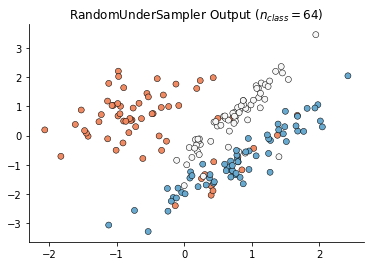

In [29]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.sample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomUnderSampler Output ($n_{class}=64)$")
pass

По умолчанию количество наблюдений будет сбалансировано, то есть каждый класс будет встречаться одинаковое количество раз. Также есть параметр ratio, который позволяет задать количество наблюдений для каждого класса (в виде целых абсолютных чисел, например, "60 наблюдений для класса 1"), которые будут включены в выборку. Например:

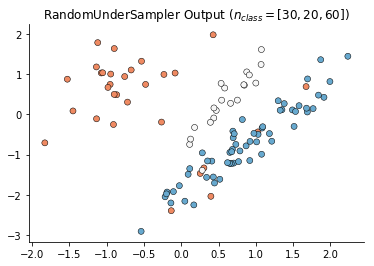

In [30]:
rus = RandomUnderSampler(random_state=0, ratio={0: 30, 1: 20, 2: 60})
rus.fit(X, y)
X_resampled, y_resampled = rus.sample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomUnderSampler Output ($n_{class}=[30, 20, 60])$")
pass

Эта техника повторной выборки полезна, если распределение классов в ваших обучающих данных отличается от распределения классов в "реальном мире" (и у вас достаточно данных, чтобы позволить себе "уменьшение выборки"). Теоретически не следует работать с такими данными, но на практике такая ситуация возникает довольно часто. Например, предположим, что у вас есть набор данных о проверке состояния почек, собранный в медицинской клинике, и вы классифицируете их как здоровые и нездоровые в соответствии с некоторой метрикой. Мы могли бы ожидать, что почки из общей популяции будут, в среднем, здоровее, чем представленные в клинических данных. Чтобы построить обобщающую модель, нам нужно будет выполнить повторную выборку на первом этапе!

## Обучающие кривые размера выборки

В контексте компромисса между смещением и разбросом наша цель при повторной выборке данных — уменьшить смещение или недообучение (вспомните модель из примера, где "один класс — это единственный класс"), причем уменьшение смещения (a) должно быть больше, чем увеличение разброса или переобучения (которое возрастает, если уменьшить количество входных наблюдений или дублировать данные). Способ количественной оценки этого подхода — изучение обучающей кривой.

Обучающая кривая иллюстрирует уровень соответствия модели по мере увеличения количества наблюдений, которые мы ей предоставляем. Краткий пример работы с обучающими кривыми я показывал в предыдущей записи. Если вы совсем с ними не знакомы, рекомендую сначала ознакомиться с этим материалом.

Мы можем построить обучающую кривую для любого метода выборки, обучая простую модель на все большем количестве выбранных точек, а затем оценивая полученную модель на полном тестовом наборе. Когда производительность модели стабилизируется относительно количества наблюдений, на которых она была обучена, это указывает на то, что этого количества достаточно для представления данных, чтобы минимизировать потерю точности.

Вот пример простой обучающей кривой, построенной на выборке данных из нашего синтетического набора:

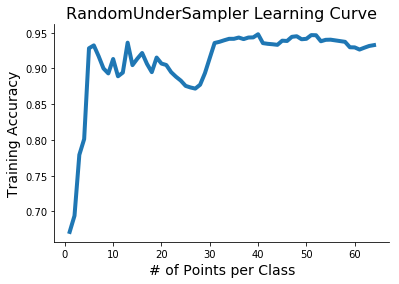

In [31]:
def learning_curve(X, y, observations=range(1, 65)):
    scores = []
    for n in observations:
        rus = RandomUnderSampler(random_state=0, ratio={0: n, 1: n, 2: n})
        rus.fit(X, y)
        X_resampled, y_resampled = rus.sample(X, y)
        score = LinearSVC().fit(X_resampled, y_resampled).score(X, y)
        scores.append(score)
    return scores

plt.plot(range(1, 65), learning_curve(X, y), linewidth=4)
plt.title("RandomUnderSampler Learning Curve", fontsize=16)
plt.gca().set_xlabel("# of Points per Class", fontsize=14)
plt.gca().set_ylabel("Training Accuracy", fontsize=14)
sns.despine()
pass

Здесь мы видим, что производительность модели стабилизируется примерно на уровне 30 наблюдений на класс. Это означает, что границы решений у метода опорных векторов (SVM), который мы обучаем на этих данных, перестают заметно изменяться после отметки в 30 точек. Это, в свою очередь, является хорошим доказательством того, что метод случайной недовыборки (RandomUnderSampler) с 64 точками, который мы используем, не внесет значительных отклонений в модель из-за недостатка данных. Поэтому, если недовыборка значительно помогает решить проблему смещения, связанного с редкими точками, её стоит применять!

Создание и проверка обучающей кривой для выборки — задача простая и действительно полезная. Обратите внимание, что для двухмерных данных с нормальным распределением, как в данном случае, количество наблюдений, необходимое для достижения стабильности, будет довольно небольшим. Однако в общем случае для достижения стабильности может понадобиться значительно больше точек, чем здесь.

## Ансамблевые методы семплирования

Два базовых метода семплирования, которые мы рассмотрели ранее, можно комбинировать для создания выборок произвольного размера. Если вы хотите увеличить количество наблюдений одного класса, а затем уменьшить другого, вы можете последовательно использовать соответствующие методы (с помощью аргумента ratio для точной настройки).

Однако такой подход может быть довольно трудоемким. Для более удобного использования библиотека sklearn предоставляет абстракции над этими двумя методами, называемые "ансамблевые семплеры".

Первым и наиболее простым из них является EasyEnsemble. EasyEnsemble можно использовать для наивного ресемплирования признаков в наборе данных. Пример его применения к нашему синтетическому набору данных выглядит следующим образом:

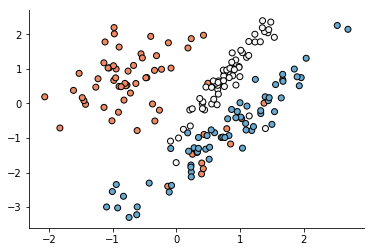

In [32]:
from imblearn.ensemble import EasyEnsemble
e = EasyEnsemble(random_state=0, n_subsets=10)
e.fit(X, y)
X_resampled, y_resampled = e.sample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled[0, :]]
plt.scatter(X_resampled[0, :, 0], X_resampled[0, :, 1], c=colors, linewidth=1, edgecolor='black')
sns.despine()

Интересной особенностью `EasyEnsemble` является то, что он выполняет операцию ресемплирования 10 раз, создавая 10 различных наборов выборок. На графике, представленном здесь, показан только первый из этих десяти наборов. Вы можете изменить количество итераций с помощью параметра n_subsets.

Еще одна возможность `EasyEnsemble` — это семплирование с возвращением.

По умолчанию `EasyEnsemble` работает так же, как RandomUnderSampler: он сокращает количество наблюдений в каждом классе до уровня численности наименьшего класса. Поскольку в классе 3 было всего 64 наблюдения, итоговая выборка содержит по 64 наблюдения для каждого класса. Таким образом, размер нашего набора данных уменьшается с (5000, 2) до (192, 2) для каждой выборки. Чтобы настроить это поведение, используется тот же API: параметр ratio, которому передается dict с желаемым количеством наблюдений для каждого класса.

Однако, на мой взгляд, `API EasyEnsemble` сложен в использовании, так как он не позволяет автоматически комбинировать методы увеличения и уменьшения выборки, например, увеличивать выборку одного класса и одновременно уменьшать выборку другого. Тем не менее, у `EasyEnsemble` есть одна особенность, отсутствующая в базовых методах семплирования: это семплирование с возвращением (replacement=True). Хотя я сомневаюсь в полезности этой функции, она существует.

Другой метод, который вы можете использовать, называется `BalanceCascade`. Это вычислительная адаптация `EasyEnsemble`. Вы передаете ему оценщик `(estimator)`, который используется для предсказания классов. При семплировании наблюдений из набора данных те из них, которые были неправильно классифицированы, остаются в наборе данных, а правильно классифицированные исключаются. В результате получается набор выборок, смещенный в сторону дублирования плохо классифицируемых наблюдений.

`EasyEnsemble` позволяет увеличивать или уменьшать выборку возвращением или без него, а BalanceCascade позволяет делать это "умным" способом (по крайней мере, так этот метод описан в документации `sklearn`). Этот метод может быть интересным, если вы хотите сосредоточиться на сложных для классификации наблюдениях, особенно при работе с редкими классами. Он позволяет, в некотором смысле, тестировать числовую устойчивость вашего классификатора, переобучая его на наборе данных, который, как известно, вызывает у него трудности (и затем проверяя изменения).


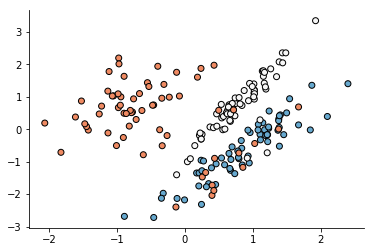

In [33]:
from imblearn.ensemble import BalanceCascade
from sklearn.linear_model import LogisticRegression
bc = BalanceCascade(random_state=0,
                    estimator=LogisticRegression(random_state=0),
                    n_max_subset=10)
bc.fit(X, y)
X_resampled, y_resampled = bc.sample(X, y)
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled[0, :]]
plt.scatter(X_resampled[0, :, 0], X_resampled[0, :, 1], c=colors, linewidth=1, edgecolor='black')
sns.despine()

## Применение

До этого мы обсудили необходимость выборки данных и рассмотрели инструменты для уменьшения и увеличения выборки в `sklearn`. Теперь давайте перейдем к практическому примеру.

Для удобства визуализации сначала будем рассматривать только первые два столбца предикторов: `V1` и `V2`.

In [34]:
import pandas as pd
df = pd.read_csv("../input/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [35]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Случаи мошенничества с кредитными картами встречаются редко, поэтому при обучении качественной модели на этом наборе данных необходимо учитывать дисбаланс классов.

Если оставить модель типа Support Vector Machine без обработки этого дисбаланса, она практически «схлопнется», не сумев найти какую-либо значимую ось в данных:

In [37]:
X = df[df.columns[:-1]].values
y = df['Class'].values

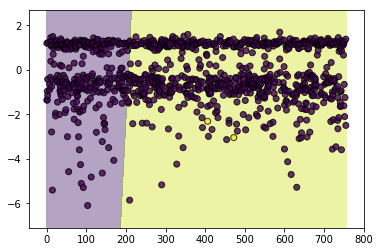

In [38]:
ax = plt.gca()
plot_decision_function(X[:, :2][:1000], y[:1000], LinearSVC().fit(X[:, :2][:5000], y[:5000]), ax)

Если мы применим повторную выборку данных, появляется более значимая закономерность. Оказывается, что транзакции, которые сильно нагружают столбец V2, почти всегда являются мошенничеством:

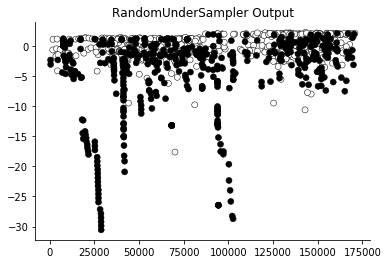

In [39]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.sample(X, y)
colors = ['white' if v == 0 else 'black' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomUnderSampler Output")
pass

Если мы обучим SVM на этих повторно выборочных данных, алгоритм теперь "осознает" это и выберет разделяющую гиперплоскость, которая учитывает этот факт:

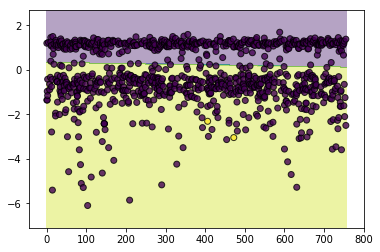

In [40]:
ax = plt.gca()
plot_decision_function(X[:, :2][:1000], y[:1000], LinearSVC().fit(X_resampled[:, :2], y_resampled), ax)

Предположим, что вы разрабатываете систему «раннего предупреждения», которая помещает транзакции, которые могут быть мошенническими, на карантин для дополнительных проверок в системе. Предположим, что после рыночных исследований и анализа затрат ваши аналитики определили, что соотношение ложных положительных и истинных положительных результатов 50:1 «оправдано». Мы могли бы реализовать настраиваемую классификационную метрику, чтобы отразить это. Мы бы обнаружили, что в этой (хотя и вымышленной, но вполне реалистичной) среде затрат стоимость модели после повторной выборки близка к стоимости модели до обработки, даже несмотря на то, что мы неправильно классифицируем большое количество законных записей.

In [41]:
def costed_error(y, y_hat):
    sum_error = 0
    for _y, _y_hat in zip(y, y_hat):
        if _y != _y_hat:
            n = 1 if _y == 0 else 50
            sum_error += n
    return sum_error

In [42]:
clf_pre = LinearSVC().fit(X[:1000], y[:1000])
clf_post = LinearSVC().fit(X_resampled, y_resampled)

In [43]:
costed_error(y, clf_pre.predict(X))

282750

In [44]:
costed_error(y, clf_post.predict(X))

25100

<!-- Whilst the recall score&mdash;the percentage of fradulent records that get flagged by this system&mdash;goes from basically zero to close to 60 percent!

from sklearn.metrics import recall_score
idx = np.where(y == 1)
y_fraud = y[idx]
y_fraud_hat_pre = clf_pre.predict(X)[idx]
y_fraud_hat_post = clf_post.predict(X)[idx]
recall_score(y_fraud, y_fraud_hat_pre)
recall_score(y_fraud, y_fraud_hat_post)

-->

## Заключение

В этом ноутбуке мы узнали о методах избыточной и недостаточной выборки: что это такое и какие проблемы они решают; о некоторых реализациях в sklearn; и о простом применении к задаче обнаружения мошеннических транзакций по кредитным картам.

Недостаточная и избыточная выборка — это всего лишь две самые простые стратегии выборки, и стратегии выборки, в свою очередь, — это самые простые способы решения проблем дисбаланса классов. Другие подходы к проблемам дисбаланса классов включают настраиваемые функции ошибки (например, создание собственного ядра для SVM) и более сложные алгоритмы выборки, такие как SMOTE и другие инструменты.